In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


saved weights can be found here: https://drive.google.com/file/d/11urR8RiGthlE0vMYTVw64Y3rzx4L7hrV/view?usp=sharing

In [2]:
### Import the libraries:
import os
import cv2
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50

from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

## Instructions for loading the dataset
- Go to your Kaggle account
- Go to accounts>generate API
- upload the ```kaggle.json``` file to colab
- Run the code below



In [3]:
!pip install kaggle 
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download harishvutukuri/dogs-vs-wolves


 94% 209M/222M [00:02<00:00, 84.1MB/s]
100% 222M/222M [00:03<00:00, 76.9MB/s]


In [4]:
!unzip /content/dogs-vs-wolves.zip

Archive:  /content/dogs-vs-wolves.zip
  inflating: data/dogs/n02085620_13964.jpg  
  inflating: data/dogs/n02085620_1617.jpg  
  inflating: data/dogs/n02085620_2204.jpg  
  inflating: data/dogs/n02085620_2887.jpg  
  inflating: data/dogs/n02085620_3409.jpg  
  inflating: data/dogs/n02085620_3423.jpg  
  inflating: data/dogs/n02085620_4207.jpg  
  inflating: data/dogs/n02085620_588.jpg  
  inflating: data/dogs/n02085620_8637.jpg  
  inflating: data/dogs/n02085782_1600.jpg  
  inflating: data/dogs/n02085782_1764.jpg  
  inflating: data/dogs/n02085782_2269.jpg  
  inflating: data/dogs/n02085782_3021.jpg  
  inflating: data/dogs/n02085782_3899.jpg  
  inflating: data/dogs/n02085936_10148.jpg  
  inflating: data/dogs/n02085936_10297.jpg  
  inflating: data/dogs/n02085936_10307.jpg  
  inflating: data/dogs/n02085936_22127.jpg  
  inflating: data/dogs/n02085936_2318.jpg  
  inflating: data/dogs/n02085936_2543.jpg  
  inflating: data/dogs/n02085936_338.jpg  
  inflating: data/dogs/n02085936_55

In [5]:
!mkdir /content/commondata
!cp -a /content/data/dogs/. /content/commondata/
!cp -a /content/data/wolves/. /content/commondata/

In [6]:
img_size = 204
photos, labels,labellist = list(),list(),list()
for file in os.listdir("/content/data/dogs"):
  output = 1
  photo = load_img("/content/data/dogs/" + file,target_size = (img_size,img_size))
  photo = img_to_array(photo)
  photos.append(photo)
  labellist.append(file)
  labels.append(output)

for file in os.listdir("/content/data/wolves"):
  output = 0
  photo = load_img("/content/data/wolves/" + file,target_size = (img_size,img_size))
  photo = img_to_array(photo)
  photos.append(photo)
  labellist.append(file)
  labels.append(output)


photos = np.asarray(photos)
labels = np.asarray(labels)
labellist = np.asarray(labellist)

dic = {"IMAGE_NAME": labellist,"LABEL": labels}
df = pd.DataFrame(dic)
print(f"The shape of ```photos``` is {photos.shape}")
print(f"The shape of ```labels``` is {labels.shape}")

np.save("photos.npy",photos)
np.save("labels.npy",labels)

The shape of ```photos``` is (2000, 204, 204, 3)
The shape of ```labels``` is (2000,)


In [ ]:
df.head()

,IMAGE_NAME,LABEL
0,n02097130_2942.jpg,1
1,n02098413_2974.jpg,1
2,n02108915_4176.jpg,1
3,n02100236_3798.jpg,1
4,n02101556_5753.jpg,1


In [7]:
DIR = "/content/commondata/"

In [8]:
def get_train_transform():
    return T.Compose([
        #T.RandomHorizontalFlip(p=0.5),
        #T.RandomRotation(15),
        T.RandomCrop(204),
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])
    
def get_test_transform():
    return T.Compose([
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])

In [9]:
class Dataset(Dataset):
    
    def __init__(self, imgs, mode = "train", transforms = None):
        
        super().__init__()
        self.imgs = imgs
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        image_name = self.imgs[idx]
        
        ### Reading, converting and normalizing image
        #img = cv2.imread(DIR_TRAIN + image_name, cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (224,224))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        #img /= 255.
        img = Image.open(DIR +  image_name)
        img = img.resize((204, 204))
        
        if self.mode == "train" or self.mode == "test":
        
            ### Preparing class label
            label = df["LABEL"][np.array(df["IMAGE_NAME"] == image_name).nonzero()[0][0]]
            #label = self.class_to_int[image_name.split(".")[0]]
            label = torch.tensor(label, dtype = torch.float32)

            ### Apply Transforms on image
            img = self.transforms(img)

            return img, label
       
            
        
    def __len__(self):
        return len(self.imgs)
    

In [ ]:
np.array(df["IMAGE_NAME"] == "n02108915_4176.jpg").nonzero()[0][0]

2

In [ ]:
df["LABEL"][np.array(df["IMAGE_NAME"] == image_name).nonzero()[0][0]]

1

In [10]:
test_size = 0.2
imgs = os.listdir(DIR) 
train_imgs, test_imgs = train_test_split(imgs, test_size = test_size)

dogs_list = [img for img in imgs if df["LABEL"][np.array(df["IMAGE_NAME"] == img).nonzero()[0][0]] == 1]
wolves_list = [img for img in imgs if df["LABEL"][np.array(df["IMAGE_NAME"] == img).nonzero()[0][0]] == 0]

print(f"The number of dog images is {len(dogs_list)}")
print(f"The number of wolf images is {len(wolves_list)}")


class_to_int = {"dog" : 1, "wolf" : 0}
int_to_class = {1 : "dog", 0 : "wolf"}

The number of dog images is 1000
The number of wolf images is 1000


In [11]:
train_dataset = Dataset(train_imgs, mode = "train", transforms = get_train_transform())
test_dataset = Dataset(test_imgs, mode = "test", transforms = get_test_transform())

train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 2,
    batch_size = 16,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    num_workers = 2,
    batch_size = 16,
    shuffle = True
)

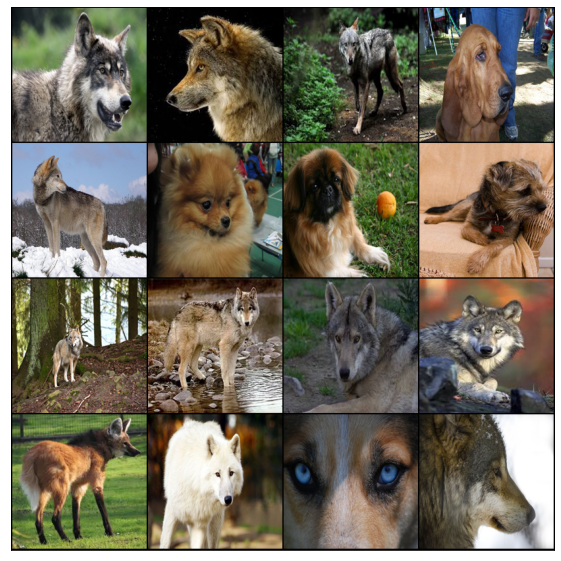

In [12]:
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break
    

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [14]:
img_size = 204
test_size = 0.2
batch_size = 32

The shape of ```photos``` is (2000, 200, 200, 3)
The shape of ```labels``` is (2000,)


In [ ]:
!mkdir /content/dataset
!cd /content/dataset
!mkdir /content/dataset/train
!mkdir /content/dataset/test


mkdir: cannot create directory ‘/content/dataset’: File exists
mkdir: cannot create directory ‘/content/dataset/train’: File exists
mkdir: cannot create directory ‘/content/dataset/test’: File exists


In [15]:
def accuracy(preds, trues):
    
    ### Converting preds to 0 or 1
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    
    ### Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    
    ### Summing over all correct predictions
    acc = np.sum(acc) / len(preds)
    
    return (acc * 100)
    
    

In [16]:
def train_one_epoch(train_data_loader):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in train_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        
        #Backward
        _loss.backward()
        optimizer.step()
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
        
    return epoch_loss, epoch_acc, total_time
        

In [17]:
def test_one_epoch(test_data_loader, best_test_acc):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in test_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    test_logs["loss"].append(epoch_loss)
    test_logs["accuracy"].append(epoch_acc)
    test_logs["time"].append(total_time)
    
    ###Saving best model
    if epoch_acc > best_test_acc:
        best_test_acc = epoch_acc
        torch.save(model.state_dict(),"resnet50_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_test_acc
        

In [28]:
model = resnet50(pretrained = True)

# Modifying Head - classifier

model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias = True),
    nn.Sigmoid()
)

In [20]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

#Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
test_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 50

In [ ]:
best_test_acc = 0
for epoch in range(epochs):
    
    ###Training
    loss, acc, _time = train_one_epoch(train_data_loader)
    
    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    ###testidation
    test_loss, acc, _time, best_test_acc = test_one_epoch(test_data_loader, best_test_acc)
    
    #Print Epoch Details
    print("\ntestidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': loss,
            'test_loss': test_loss}
            ,f"/content/gdrive/My Drive/modelofdogvwolf{epoch}.pth" )


Training
Epoch 1
Loss : 0.898
Acc : 53.5625
Time : 38.4105

testidating
Epoch 1
Loss : 0.898
Acc : 59.25
Time : 7.1333

Training
Epoch 2
Loss : 0.6878
Acc : 60.0
Time : 41.5265

testidating
Epoch 2
Loss : 0.6878
Acc : 49.75
Time : 8.2884

Training
Epoch 3
Loss : 0.6847
Acc : 57.0
Time : 52.1995

testidating
Epoch 3
Loss : 0.6847
Acc : 59.5
Time : 17.8629

Training
Epoch 4
Loss : 0.6542
Acc : 62.5625
Time : 48.1206

testidating
Epoch 4
Loss : 0.6542
Acc : 62.75
Time : 8.0969

Training
Epoch 5
Loss : 0.6174
Acc : 68.375
Time : 42.9007

testidating
Epoch 5
Loss : 0.6174
Acc : 69.0
Time : 8.6351

Training
Epoch 6
Loss : 0.6178
Acc : 66.25
Time : 42.4619

testidating
Epoch 6
Loss : 0.6178
Acc : 60.75
Time : 8.432

Training
Epoch 7
Loss : 0.6067
Acc : 68.75
Time : 49.7146

testidating
Epoch 7
Loss : 0.6067
Acc : 64.75
Time : 13.3301

Training
Epoch 8
Loss : 0.5697
Acc : 72.875
Time : 47.0262

testidating
Epoch 8
Loss : 0.5697
Acc : 72.75
Time : 7.5246

Training
Epoch 9
Loss : 0.5595
Acc : 7

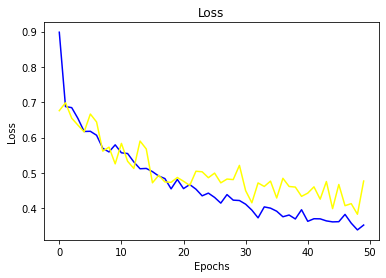

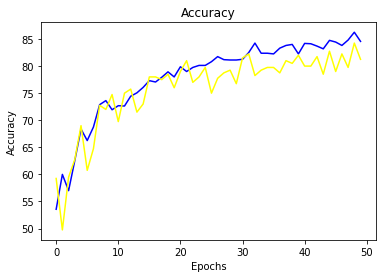

In [ ]:
### Plotting Results

#Loss
plt.title("Loss")
plt.plot(train_logs["loss"], color = 'blue')
plt.plot(test_logs["loss"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#Accuracy
plt.title("Accuracy")
plt.plot(train_logs["accuracy"], color = 'blue')
plt.plot(test_logs["accuracy"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [32]:
model.load_state_dict(torch.load("/content/gdrive/MyDrive/modelofdogvwolf41.pth"))

SyntaxError: ignored

In [36]:
model.load_state_dict(torch.load("/content/gdrive/MyDrive/modelofdogvwolf41.pth")['model_state_dict'])

<All keys matched successfully>

In [37]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

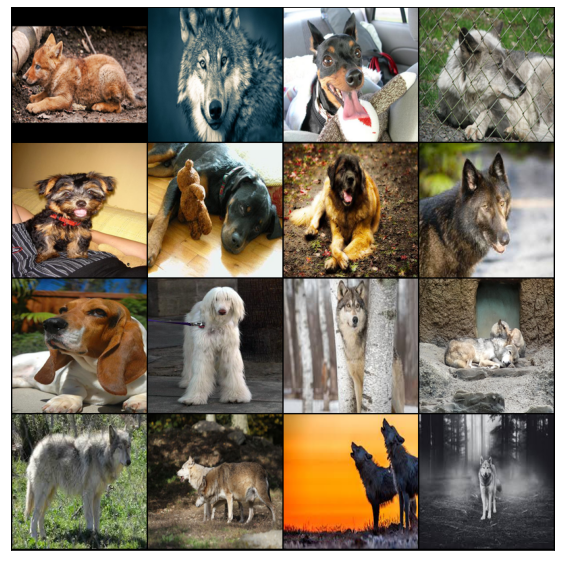

In [237]:
for images, labels in test_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    #ax.imshow(images[0].permute(1,2,0))
    image = images
    break


tensor([0.9461], device='cuda:0', grad_fn=<SelectBackward0>)


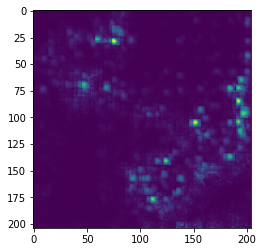

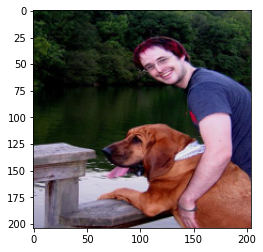

In [152]:
index = 14

image = image.to(device)

image.requires_grad_()

op = model(image)
#print(op)
op = op[index]
print(op)
id = op.argmax()
opmax = op[id]

opmax.backward()

saliency, _ = torch.max(image.grad[index].data.abs(), dim=0) 
saliency = saliency.reshape(204, 204)
s = np.array(saliency.cpu())
s = np.rot90(s,1)
s = np.rot90(s,1)
s = np.rot90(s,1)
s = np.rot90(s,1)
s = np.rot90(s,1)
s = np.rot90(s,1)
plt.imshow(s)
plt.figure()
imagee= image[index].cpu().detach().numpy()
imagee = imagee.transpose(2,1,0)
imagee = np.rot90(imagee,1)
imagee = np.rot90(imagee,1)
imagee = np.rot90(imagee,1)
plt.imshow(imagee)


In [ ]:
s = np.rot90(s,1)
s = np.rot90(s,1)
s = np.rot90(s,1)


imagee = np.rot90(imagee,1)

imagee = np.rot90(imagee,1)
imagee = np.rot90(imagee,1)


In [273]:
for images, labels in test_data_loader:
  image = images

  break

index = 0
image = image.to(device)


In [260]:

def occlusion(model, image, label, occ_size = 10, occ_stride = 5, occ_pixel = 0.5):
  
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    image = torch.rot90(image,1,[2,3])


    image = image.to(device)
    plt.figure()
    #imagee= image[index].clone().cpu().detach().numpy()
    #imagee = imagee.transpose(2,1,0)
    #plt.imshow(imagee)
    #return 0

    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #occlude
            input_image[:, :,w_start:w_end, h_start:h_end] = occ_pixel
            
            #predict
            output = ((model(input_image))**(label))*((1-model(input_image))**(1-label))
            prob = output.tolist()[0][0]
            
            heatmap[h, w] = prob 

    return heatmap

tensor(0.0126, device='cuda:0', grad_fn=<SelectBackward0>)


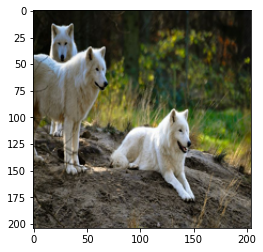

In [274]:
index = 0

image = image.to(device)
op = model(image)
op = op[index]
id = op.argmax()
opmax = op[id]
print(op[index])
plt.figure()
imagee= image[index].cpu().detach().numpy()
imagee = imagee.transpose(2,1,0)
imagee = np.rot90(imagee,1)
imagee = np.rot90(imagee,1)
imagee = np.rot90(imagee,1)
plt.imshow(imagee)

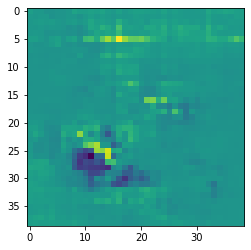

In [275]:
plt.imshow(occlusion(model,image,1))